# Indicators for temperature assessment 

For questions about this notebook, please contact Guarav Ganti <gaurav.ganti@climateanalytics.org>.

In [1]:
import pyam 
import os 
import pandas as pd 
import numpy as np 
from scmdata import ScmRun 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
import sys
import string 
sys.path.append('..')
from plotting import plot_temperature_data
from utils import process_temperature_data

<IPython.core.display.Javascript object>

# Read in data 

We read in the MAGICC output to compute the temperature indicators 

In [2]:
magicc_file = os.path.join(
    '..','output',
#     'magicc_output_2021-06-03.csv'
#     'magicc_output_2021-06-04.csv'
#    'magicc_output_2021-06-05.csv'
    'magicc_output_2021-06-07.csv'
)

In [3]:
magicc_data = ScmRun(
    pd.read_csv(
        magicc_file,
        index_col=0
    )
)

In [4]:
magicc_data.meta.scenario.unique()

array(['bp_Rapid_qrw', 'bp_Net_Zero_eqw', 'bp_Rapid_rms',
       'weo_SDS_2020_qrw', 'weo_SDS_2020_rms', 'equinor_Rebalance_rms',
       'ieasr15_NZ2021_rms', 'equinor_Rebalance_qrw',
       'ieasr15_NZ2021_qrw', 'bp_Net_Zero_rms', 'bp_Rapid_eqw',
       'bp_Net_Zero_qrw', 'weo_SDS_2020_eqw', 'equinor_Rebalance_eqw',
       'ieasr15_NZ2021_eqw', 'shell_sky_eqw', 'shell_sky_qrw',
       'shell_sky_rms'], dtype=object)

# Calculate exceedance probabilites 

In [5]:
temperature, _ = process_temperature_data(magicc_data)

In [6]:
def calculate_probability_of_exceedence(scen, threshold):
    # Filter for the necessary scenario 
    _scenario = (
        temperature
        .filter(scenario = scen)
        .timeseries()
        .reset_index(drop=True)
    )
    _scenario.columns = _scenario.columns.map(lambda x: x.year)

    # Construct an ordered pandas dataframe 
    _ordered = pd.DataFrame(
        np.sort(_scenario, axis=0),
        columns = _scenario.columns
    )

    # Calculate exceedance probability 
    exceedance = _ordered.apply(
        lambda x: 100 * len(x[x>threshold])/len(x)
    )

    exceedance.name = '{}_exceedance_{}'.format(scen, threshold)

    return pd.DataFrame(exceedance).pivot_table(index=None, values=[exceedance.name], columns='time') 

In [7]:
exceedance_frame = pd.DataFrame()

In [8]:
for scen in magicc_data.meta.scenario.unique():
    exceedance_frame = (
        exceedance_frame.append(
            calculate_probability_of_exceedence(scen, 1.5)
        ).append(
            calculate_probability_of_exceedence(scen, 2)
        )
    )

In [9]:
exceedance_frame['max'] = exceedance_frame.max(1)

In [10]:
exceedance_frame_to_write = exceedance_frame[[2100, 'max']].astype(int)

In [11]:
exceedance_frame_to_write.to_excel(
    os.path.join('..', 'output', 't1_exceedance_probability.xlsx')
)

# Prepare emission data

In [12]:
emission_data = magicc_data.filter(
    run_id = [0,601,1201,1801,2401, 3001, 3601, 4201, 4801], 
    variable = [
        'Emissions|CO2|MAGICC Fossil and Industrial',
        'Emissions|CO2|MAGICC AFOLU'
    ]
).timeseries()

In [13]:
emission_data.columns = emission_data.columns.map(lambda x: x.year)

In [14]:
emi_for_plot = pyam.IamDataFrame(emission_data)

In [15]:
emi_for_plot = emi_for_plot.rename(
    {'variable':{"Emissions|CO2|MAGICC Fossil and Industrial":"0_Fossil fuel and industry",
    "Emissions|CO2|MAGICC AFOLU":"1_AFOLU"}
    }
)

In [16]:
enco2 = emi_for_plot.filter(variable = "0_Fossil fuel and industry")
afolu = emi_for_plot.filter(variable = '1_AFOLU')
co2 = pyam.concat([enco2, afolu]).convert_unit("Gt C / yr", "Gt CO2/yr", context="AR4GWP100")

In [17]:
def plot_exceedance(ax, level, scenario_colors):

    for scenario in scenario_colors.keys():
        _scenario_full = '{}_exceedance_{}'.format(scenario, level)
        (
            exceedance_frame
            .loc[_scenario_full, range(2010,2101,1)]
            #.astype(int)
            .T.plot(color = scenario_colors[scenario], ax=ax)
        )
    ax.set_ylim(0,100)

In [18]:
scenario_colors = {
    'bp_Net_Zero_qrw':'#daa51b',
    'ieasr15_NZ2021_qrw':'#24796c',
    'shell_sky_qrw':'#5d69b1',
    'equinor_Rebalance_qrw':'#2f8ac4',
    'bp_Rapid_qrw':'#e58606',
    'weo_SDS_2020_qrw':'#cc61b0'
}

In [19]:
scenario_colors_for_main = [(x,y) for x,y in zip(scenario_colors.keys(), scenario_colors.values())]

In [20]:
scenario_colors_for_panel_1 = scenario_colors_for_main[0:2]
scenario_colors_for_panel_2 = scenario_colors_for_main[2:]

In [21]:
exceed_levels = [1.5,2]

In [22]:
import matplotlib
font = {'size'   : 17}

matplotlib.rc('font', **font)

bp_Net_Zero_qrw [1.64614488] [1.52916915] [1.77158426]
ieasr15_NZ2021_qrw [1.55690505] [1.4526128] [1.67030193]
shell_sky_qrw [1.81350298] [1.68473197] [1.9474494]
equinor_Rebalance_qrw [1.72776809] [1.60107032] [1.86641658]
bp_Rapid_qrw [1.72500955] [1.59924647] [1.85952102]
weo_SDS_2020_qrw [1.67915479] [1.55650045] [1.81083603]


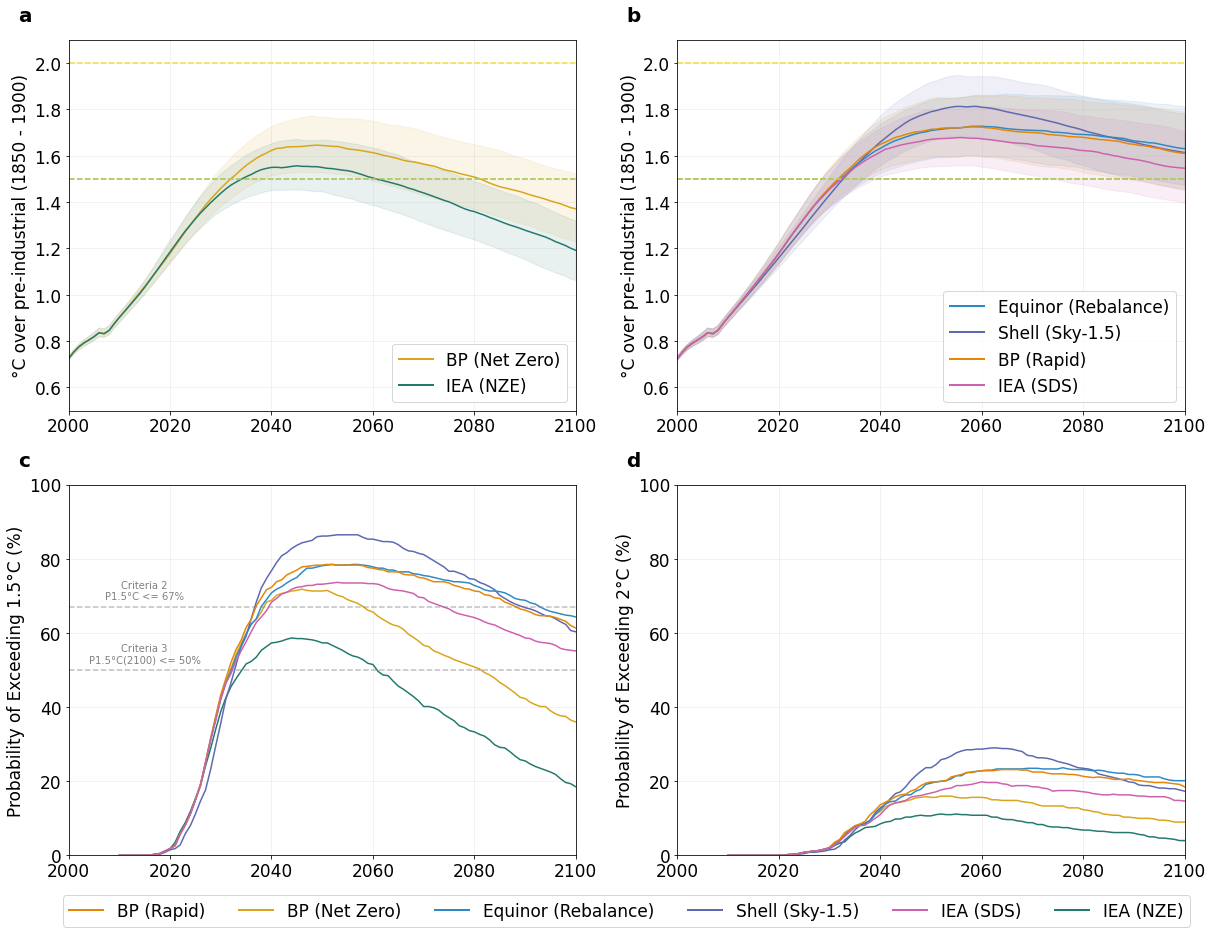

In [23]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
plot_temperature_data(magicc_data, ax[0,0], scenario_colors_for_panel_1)
plot_temperature_data(magicc_data, ax[0,1], scenario_colors_for_panel_2)

ax[0,0].legend(
    handles = [
        Line2D([0], [0], color='#daa51b', lw=2, label='BP (Net Zero)'),
        Line2D([0], [0], color='#24796c', lw=2, label='IEA (NZE)'),
    ],
    loc=4
)
ax[0,1].legend(
    handles = [
        Line2D([0], [0], color='#2f8ac4', lw=2, label='Equinor (Rebalance)'),
        Line2D([0], [0], color='#5d69b1', lw=2, label='Shell (Sky-1.5)'),
        Line2D([0], [0], color='#e58606', lw=2, label='BP (Rapid)'),
        Line2D([0], [0], color='#cc61b0', lw=2, label='IEA (SDS)'),
    ],
    loc=4
)

for i, level in enumerate(exceed_levels):
    plot_exceedance(ax[1,i], level, scenario_colors)
    ax[1,i].grid(alpha=0.2)
    ax[1,i].set_xlabel("")

ax[1,0].set_ylabel("Probability of Exceeding 1.5°C (%)")
ax[1,1].set_ylabel("Probability of Exceeding 2°C (%)")

# Construct legend 
legend_elements = [
    Line2D([0], [0], color='#e58606', lw=2, label='BP (Rapid)'),
    Line2D([0], [0], color='#daa51b', lw=2, label='BP (Net Zero)'),
    Line2D([0], [0], color='#2f8ac4', lw=2, label='Equinor (Rebalance)'),
    Line2D([0], [0], color='#5d69b1', lw=2, label='Shell (Sky-1.5)'),
    Line2D([0], [0], color='#cc61b0', lw=2, label='IEA (SDS)'),
    Line2D([0], [0], color='#24796c', lw=2, label='IEA (NZE)'),                  
]

# Legend
ax[1,0].legend(handles=legend_elements, loc='center', ncol=6, bbox_to_anchor = (1.1, -0.15))

ax[0,1].set_xlim(2000,2100)
ax[0,0].set_xlim(2000,2100)
ax[1,1].set_xlim(2000,2100)
ax[1,0].set_xlim(2000,2100)

ax[0,0].set_ylim(0.5,2.1)
ax[0,1].set_ylim(0.5,2.1)

ax[0,1].grid(alpha=0.2)
ax[0,0].grid(alpha=0.2)

# Add exceedance explanations
ax[1,0].axhline(50, color = "grey", linestyle = "dashed", alpha=0.5)
ax[1,0].axhline(67, color = "grey", linestyle = "dashed", alpha=0.5)

# Annotation
ax[1,0].annotate("Criteria 3\nP1.5°C(2100) <= 50%", xy = (2015, 52), size=10, color = "grey", ha="center")
ax[1,0].annotate("Criteria 2\nP1.5°C <= 67%", xy = (2015, 69), size=10, color = "grey", ha="center")

# Add annotations 
for n, axs in enumerate(ax[0]):  
    axs.text(-0.1, 1.05, string.ascii_lowercase[n], transform=axs.transAxes, 
            size=20, weight='bold')

for n, axs in enumerate(ax[1]):  
    axs.text(-0.1, 1.05, string.ascii_lowercase[n+2], transform=axs.transAxes, 
            size=20, weight='bold')

In [24]:
fig.savefig(
    os.path.join('figures', 'fig3_temperature_and_exceedance_plot.png'),
    dpi=450,
    bbox_inches='tight'
)

In [25]:
fig.savefig(
    os.path.join('figures', 'fig3_temperature_and_exceedance_plot.svg'),
    dpi=800,
    bbox_inches='tight'
)